In [6]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
# tryig to set the target variable as the fatal or non fatal accindents in France metropolitan area
#Step 2/ Pre-processing and feature engineering : Deadline Friday, 14th of July
#Following the observations made in the previous step, you will have to clean your dataset and perform the pre-processing steps.
#If necessary, you will have to transform and/or add features and enrich your dataset.
#The objective at the end of this step is to have a dataset ready to perform in-depth analysis and/or modeling using Randon Forest Classifier 

In [7]:
df = pd.read_csv("./data/230907_basic_table_for_analysis_cleaned.csv", index_col=0, low_memory=False)

In [8]:
# cleanning variables that might not be used in the model
df['date']= pd.to_datetime(df.date,format='%Y-%m-%d')
df['year'] = df['date'].dt.year.astype(int)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['actp'] = le.fit_transform(df['actp'].astype(str))
df['hrmn'] = le.fit_transform(df['hrmn'].astype(str))

In [11]:
#filtering just the metropolitan area of France
df_M = df[df['metropolitan'] == 1]
#checking if is correct
df_M['metropolitan'].describe()

count    2421738.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: metropolitan, dtype: float64

In [12]:
#cleanning variables that might not be used in the model
# grav removed because is similat to target 
df_rf = df_M.drop(['num_veh','adr','date','holiday','lat', 'long','grav'], axis=1)

In [13]:
#split the data for modeling
# 2005 to 2019 for trainning  and 2020 to 2021 to test

# Filter data for the training period (2005-2018)
train_data = df_rf[(df_rf['an'] >= 2005) & (df_rf['an'] <= 2019)]

# Filter data for the testing period (2019-2021)
test_data = df_rf[(df_rf['an'] >= 2020) & (df_rf['an'] <= 2021)]
 #Separate features and target variable
X_train = train_data.drop('fatal', axis=1)  # Features for training
y_train = train_data['fatal']  # Target variable for training

# Separate features and target variable
X_test = test_data.drop('fatal', axis=1)  # Features for training
y_test = test_data['fatal']  # Target variable for training


In [14]:
# Feature scaling for better results 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle class imbalance using SMOTE
# SMOTE (synthetic minority oversampling technique) is one of the most 
# commonly used oversampling methods to solve the imbalance problem. 
# It aims to balance class distribution by randomly increasing minority 
# class examples by replicating them. SMOTE synthesises new minority 
# instances between existing minority instances. https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Instantiate Random Forest Classifier with hyperparameter tuning
forest = RandomForestClassifier(
    n_estimators=100,  # You can adjust this #100
    max_depth=10,       # You can adjust this
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

# Train the model
forest.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_test_preds = forest.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest:\n', report)

Classification Report Random Forest:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    215726
           1       0.08      0.62      0.15      5539

    accuracy                           0.82    221265
   macro avg       0.54      0.72      0.53    221265
weighted avg       0.97      0.82      0.88    221265



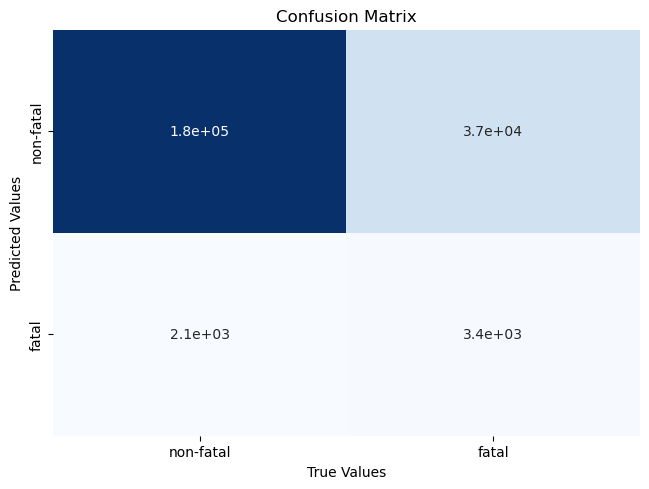

In [16]:
# import classifier
from sklearn.ensemble import RandomForestClassifier

# import metrics
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# import evaluation tools
from sklearn.model_selection import KFold, cross_val_score
# create confusion matrix# create confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = df_rf.fatal.values
dataframe = pd.DataFrame(matrix, index=['non-fatal', 'fatal'], 
                         columns=['non-fatal', 'fatal'])

# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()

In [19]:

# Assuming you have already calculated the confusion matrix
matrix = confusion_matrix(y_test, y_test_preds)

# Create a DataFrame from the confusion matrix
class_names = df_rf.fatal.values
dataframe = pd.DataFrame(matrix, index=['non-fatal', 'fatal'], 
                         columns=['non-fatal', 'fatal'])

# Display the confusion matrix as text
print("Confusion Matrix:")
print(dataframe)

Confusion Matrix:
           non-fatal  fatal
non-fatal     178574  37152
fatal           2094   3445


In [22]:
# etract thh values from DataFrame

true_negative = dataframe.loc['non-fatal', 'non-fatal']
false_positive = dataframe.loc['non-fatal', 'fatal']
false_negative = dataframe.loc['fatal', 'non-fatal']
true_positive = dataframe.loc['fatal', 'fatal']

# Print the values
print("True Negatives: the model correctly predicted", true_negative, " as non-fatal")
print("False Positives: the model incorrectly predicted", false_positive, "as *fatal")
print("False Negatives:the model incorrectly predicted", false_negative,"as *non-fatal")
print("True Positives:the model correctly predicted", true_positive,"as fatal")



True Negatives: the model correctly predicted 178574  as non-fatal
False Positives: the model incorrectly predicted 37152 as *fatal
False Negatives:the model incorrectly predicted 2094 as *non-fatal
True Positives:the model correctly predicted 3445 as fatal


Length of feature_names: 39
Length of importances: 39


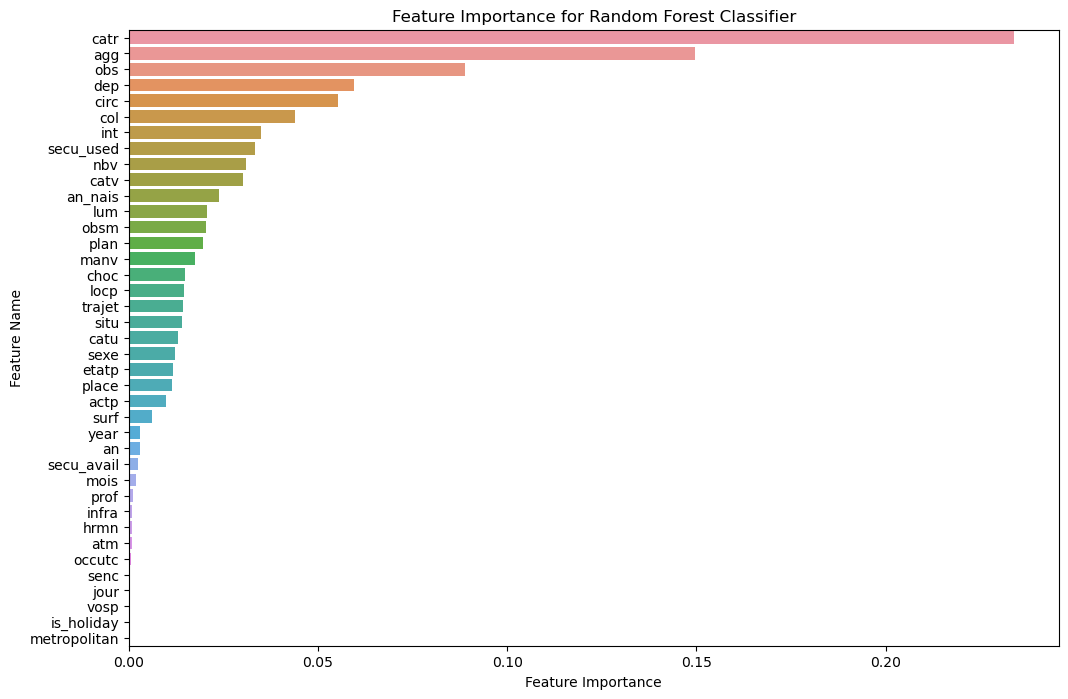

In [44]:
# estimate the feature impotance for thi model
import numpy as np

# Access feature importances from the trained model
importances = forest.feature_importances_

feature_names = df_rf.drop(columns=['fatal']).columns.tolist()

# Check the lengths of feature_names and importances
print("Length of feature_names:", len(feature_names))
print("Length of importances:", len(importances))

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Random Forest Classifier')
plt.show()



